# Submission by:
    Name: Sarthak Punjabi
    Student Number: 21183147
    Module Name: CS4168 Data Mining
    Lab Number: 1
    
    

# Lab - 4: Comparison of Classifiers

## `Importing the required libraries`

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn. preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## `Importing the dataset `

In [74]:
df = pd.read_csv("../datasets/seeds.csv")

## `Exploratory Data Analysis`

### Getting a quick glance on the dataset. 

In [75]:
df.head(10)

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1
6,14.69,14.49,0.8799,5.563,3.259,3.586,5.219,1
7,14.11,14.10,0.8911,5.420,3.302,2.700,5.000,1
8,16.63,15.46,0.8747,6.053,3.465,2.040,5.877,1
9,16.44,15.25,0.8880,5.884,3.505,1.969,5.533,1


In [76]:
df.tail(10)

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
200,12.38,13.44,0.8609,5.219,2.989,5.472,5.045,3
201,12.67,13.32,0.8977,4.984,3.135,2.300,4.745,3
202,11.18,12.72,0.8680,5.009,2.810,4.051,4.828,3
203,12.70,13.41,0.8874,5.183,3.091,8.456,5.000,3
204,12.37,13.47,0.8567,5.204,2.960,3.919,5.001,3
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


From here we can see that there are no missing values so we can skip the missing value data preparation step.

In [77]:
df.describe()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


We can see that the dataset does not contain any null values, which makes it easier to deal with and cuts down on the preprocessing time.

In [78]:
df.isnull().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

Here, we check if there are any values that are zero in the dataset that can be useless and might make the prediction algorithms not work the way it is supposed to be.

In [79]:
df[(df.values == 0).any(axis=1)].index.values.tolist()

[]

Here, we calculate the distribution of the dataset into the three different parts in the target variable being "type".

In [80]:
df["type"].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

Here, we visualise the variables by box plot to have a look at the outliers that we have in order to include the outlier handling process to the entire process. 

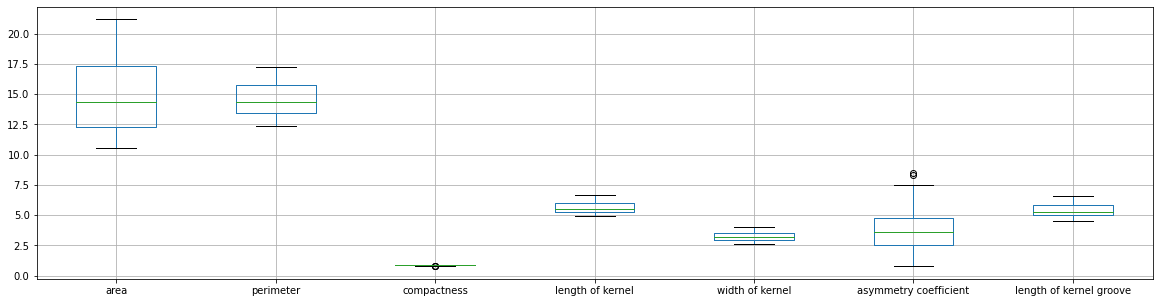

In [81]:
df.loc[:, :"length of kernel groove"].boxplot(figsize=(20, 5))
plt.show()

## Data Preparation

We will attempt training SVM, Random Forest, and K-Nearest Neighbor classifiers. We will tune their parameters, compare them and choose the best classifier for our problem. Here we will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we will apply later. The use of his pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

First, we need to prepare two lists of column names. The list `names_outliers` contains the names of the three columns to which we will apply log transformation followed by `RobustScaler`. The list `names_no_outliers` contains the names of all other predictor columns to which we will apply `StandardScaler`.

In [82]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ["type"]]

# define column groups with same data preparation
names_outliers = ["area", "perimeter", "compactness"]
names_no_outliers = list(set(names_all) - set(names_outliers))

In [83]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [84]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [85]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Here, we separate the columns into target and predictor and then split the dataset into training and testing dataset.

In [86]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter `stratify=y` ensures that the classes are represented in the same proportion in both the training and the test sets.

Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

## Grid Search for Best Parameters of Classifiers

Next, we train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we will build another pipeline which includes the preprocessing pipeline and the SVM classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [87]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.947:
Best parameters:  {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


Next, we train an Random Forest classifier with the training set and a range of possible parameters in order to find the best parameters. To do this we will build another pipeline which includes the preprocessing pipeline and the Random Forest classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [88]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.941:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30}


Next, we train an K-Nearest Neighbor classifier with the training set and a range of possible parameters in order to find the best parameters. To do this we will build another pipeline which includes the preprocessing pipeline and the K-Nearest Neighbor classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [89]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'knn__n_neighbors' : [10,20,30],
    'knn__algorithm': ["ball_tree", "kd_tree", "brute"]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
knn_best_params = search.best_params_
knn_best_model = search.best_estimator_

Best CV score = 0.929:
Best parameters:  {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 10}


Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score

## Compare Classifiers on Test Set

In [90]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0]

In [91]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score = evaluate_model(X_test, y_test, RF_best_model)
knn_accuracy, knn_precision, knn_recall, knn_f1_score = evaluate_model(X_test, y_test, knn_best_model)

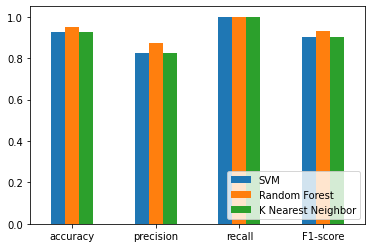

In [92]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
knn_metrics = np.array([knn_accuracy, knn_precision, knn_recall, knn_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'K Nearest Neighbor': knn_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

### Train a Final Model

Finally, we can train an SVM model with all data we have, assuming that the more data we have the better the model.

In [93]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

In [94]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))